# Imports

In [1]:
# Some environmental dependencies. 
# These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

import time, sys, os
import h5py

%pylab
%matplotlib inline

# re-defining plotting defaults
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'font.size': 30})



Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
import emcee

In [3]:
import fsps
import sedpy
import prospect

# initialize model
from prospect.models import model_setup

# set likelihood
from prospect.likelihood import lnlike_spec, lnlike_phot, write_log

# something else
from prospect.io import write_results

# Minimizing data
from prospect import fitting
from scipy.optimize import minimize

# Setup

In [4]:
# load in model parameter file

clargs = {'param_file':'demo_mock_params.py'}
run_params = model_setup.get_run_params(argv='demo_mock_params.py', **clargs)
print run_params


{'tau': 3.0, 'verbose': True, 'niter': 512, 'normalize_spectrum': False, 'whi': 7200.0, 'initial_disp': 0.1, 'outfile': 'output/demo_mock', 'nburn': [32, 32, 64], 'maxfev': 5000, 'do_powell': True, 'nwalkers': 128, 'mass': 10000000.0, 'param_file': 'demo_mock_params.py', 'ftol': 5e-06, 'logzsol': -0.5, 'dust2': 0.3, 'tage': 12.0, 'zcontinuous': 1, 'wlo': 3750.0, 'debug': False, 'snr': 20.0, 'add_noise': False, 'logify_spectrum': False}


Our model is composed of four components:

* an stellar population synthesis (SPS) model for the underlying physical parameters,
* a noise model for the underlying calibration vector,
* an underlying statistical model composed of a set of parameters, priors, etc., and
* a set of observations we are trying to fit.


In [5]:
# load sps model (default)
sps = model_setup.load_sps(**run_params)

In [6]:
# load noise model (none)
spec_noise, phot_noise = model_setup.load_gp(**run_params)

In [7]:
# demo model
model = model_setup.load_model(**run_params)

In [8]:
# demo data (generated from the script)
obs = model_setup.load_obs(**run_params)

reading py script demo_mock_params.py


In [9]:
# likelihood

def lnprobfn(theta):
    """Given a parameter vector and a dictionary of observational data and a model object, 
    return the ln of the posterior. This requires that an sps object (and if using spectra 
    and gaussian processes, a GP object) be instantiated.
    """

    lnp_prior = model.prior_product(theta)
    if isfinite(lnp_prior):
        
        # Generate mean model
        t1 = time.time()
        try:
            mu, phot, x = model.mean_model(theta, obs, sps=sps)
        except(ValueError):
            return -np.infty
        d1 = time.time() - t1

        # Noise modeling
        if spec_noise is not None:
            spec_noise.update(**model.params)
        if phot_noise is not None:
            phot_noise.update(**model.params)
        vectors = {'spec': mu, 'unc': obs['unc'],
                   'sed': model._spec, 'cal': model._speccal,
                   'phot': phot, 'maggies_unc': obs['maggies_unc']}

        # Calculate log-likelihoods
        t2 = time.time()
        lnp_spec = lnlike_spec(mu, obs=obs, spec_noise=spec_noise, **vectors)
        lnp_phot = lnlike_phot(phot, obs=obs, phot_noise=phot_noise, **vectors)
        d2 = time.time() - t2
        if verbose:
            write_log(theta, lnp_prior, lnp_spec, lnp_phot, d1, d2)

        return lnp_prior + lnp_phot + lnp_spec
    
    else:
        return -np.infty

# Running Prospector

### Outputs

In [10]:
# Can we write out output to HDF5 file? If not, dump at end

outroot = "{0}_{1}".format(run_params['outfile'], int(time.time()))
try:
    hfilename = outroot + '_mcmc.h5'
    hfile = h5py.File(hfilename, "a")
    print("Writing to file {}".format(hfilename))
    write_results.write_h5_header(hfile, run_params, model)
    write_results.write_obs_to_h5(hfile, obs)
except:
    hfile = None

# doesn't give output because h5py is not downloaded

Writing to file output/demo_mock_1495734732_mcmc.h5
Could not JSON serialize mock_params, pickled instead


### Model Preview

In [11]:
print 'Free params:', model.free_params
print 'Fixed params:', model.fixed_params

Free params: ['mass', 'logzsol', 'tau', 'tage', 'dust2']
Fixed params: ['zred', 'sfh', 'pmetals', 'sfstart', 'tburst', 'fburst', 'dust1', 'dust_index', 'dust1_index', 'dust_tesc', 'dust_type', 'add_dust_emission', 'duste_umin', 'tpagb_norm_type', 'add_agb_dust_model', 'agb_dust', 'add_neb_emission', 'gas_logz', 'gas_logu', 'phot_jitter']


So we're fitting for 5 parameters here:

* stellar mass $M_\star$,
* metallicity $\log Z/Z_\odot$,
* star formation timescale $\tau$ for an exponentially declining star formation history (SFH),
* age $t$ of the galaxy, and
* dust attenuation of old stellar populations $A_V$.


### SED Preview

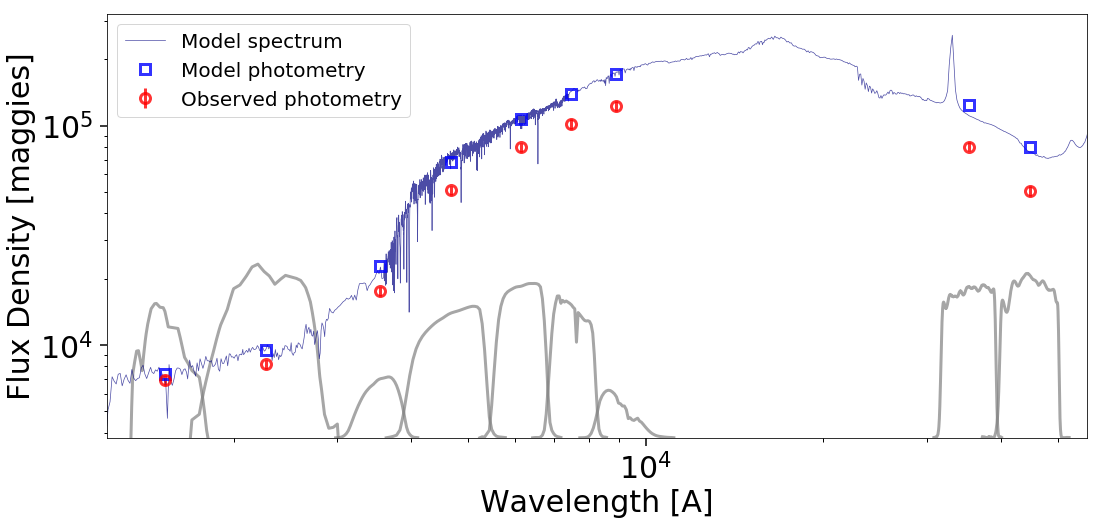

In [12]:
wspec = sps.csp.wavelengths # spectral wavelengths
wphot = array([f.wave_effective for f in obs['filters']]) # photometric effective wavelengths
wphot_width = array([f.effective_width for f in obs['filters']]) # photometric effective widths

initial_theta = model.rectify_theta(model.initial_theta) # initial parameters
mspec_init, mphot_init, mextra_init = model.mean_model(initial_theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec_init)
ymin, ymax = temp.min()*0.8, temp.max()/0.8

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
loglog(wspec, mspec_init, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

### Minimization Step

In [13]:
def chisqfn(theta):
    """Negative of lnprobfn for minimization, and also handles passing in
    keyword arguments which can only be postional arguments when using scipy
    minimize.
    """
    return -lnprobfn(theta)

verbose=False # don't output function calls

# start minimization
min_method = 'Nelder-Mead'
ts = time.time()
min_results = minimize(chisqfn, initial_theta, method=min_method)
pdur = time.time() - ts

# reinitialize fit
initial_center = fitting.reinitialize(min_results.x, model, edge_trunc=run_params.get('edge_trunc', 0.1))
initial_prob = -1 * min_results['fun']

# output results
print('done {0} in {1}s'.format(min_method,pdur))
print('best {0} guess: {1}'.format(min_method,initial_center))
print('best {0} lnp: {1}'.format(min_method,initial_prob))

done Nelder-Mead in 23.2576210499s
best Nelder-Mead guess: [  6.86764344e+06  -3.48191864e-01   1.21694713e+00   5.81991078e+00
   2.26567514e-01]
best Nelder-Mead lnp: -76.7735908771


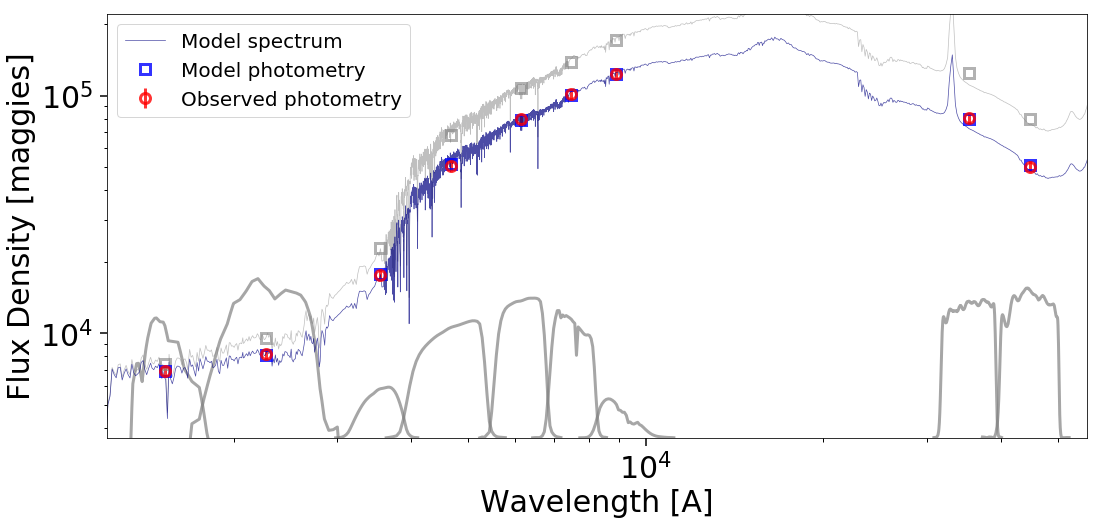

In [14]:
# new model after minimization
theta = model.rectify_theta(min_results.x) # initial parameters
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.8

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
loglog(wspec, mspec_init, lw=0.7, color='gray', alpha=0.5)
errorbar(wphot, mphot_init, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='gray', markeredgewidth=3, alpha=0.6)
loglog(wspec, mspec, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()

### Sampling the Posterior

In [15]:
try:
    from emcee.utils import MPIPool
    pool = MPIPool(debug=False, loadbalance=True)
    if not pool.is_master():
        # Wait for instructions from the master process.
        pool.wait()
        sys.exit(0)
except(ImportError, ValueError):
    pool = None
    print('Not using MPI')

Not using MPI


In [16]:
def halt(message):
    """Exit, closing pool safely.
    """
    print(message)
    try:
        pool.close()
    except:
        pass

In [17]:
# sampling

postkwargs = {}

fout = sys.stdout
fnull = open(os.devnull, 'w')
sys.stdout = fnull

tstart = time.time()
out = fitting.run_emcee_sampler(lnprobfn, initial_center, model,
                                postkwargs=postkwargs, initial_prob=initial_prob,
                                pool=pool, hdf5=hfile, **run_params)
esampler, burn_p0, burn_prob0 = out
edur = time.time() - tstart

sys.stdout = fout

print('done emcee in {0}s'.format(edur))

/usr/local/anaconda3/envs/py27/lib/python2.7/site-packages/prospect-73a489a-py2.7.egg/prospect/models/priors.py:54: RuntimeWarning: invalid value encountered in log


done emcee in 1075.23709512s


In [18]:
out

(<emcee.ensemble.EnsembleSampler at 0x7f29a86b0590>,
 array([  5.76320074e+06,  -8.23576549e-02,   7.12349412e-01,
          3.79584221e+00,   1.34271967e-01]),
 -76.649326321884857)

In [19]:
write_results.write_pickles(run_params, model, obs, esampler, min_results,
                            outroot=outroot, toptimize=pdur, tsample=edur,
                            sampling_initial_center=initial_center,
                            post_burnin_center=burn_p0,
                            post_burnin_prob=burn_prob0)

if hfile is None:
    hfile = hfilename
write_results.write_hdf5(hfile, run_params, model, obs, esampler, min_results,
                         toptimize=pdur, tsample=edur,
                         sampling_initial_center=initial_center,
                         post_burnin_center=burn_p0,
                         post_burnin_prob=burn_prob0)

halt('Finished')

TypeError: expected str, bytes or os.PathLike object, not File

In [20]:
import plot_utils as pread
from prospect.io import read_results

In [22]:
res, pr, mod = read_results.results_from("output/demo_mock_1495734732_mcmc.h5")

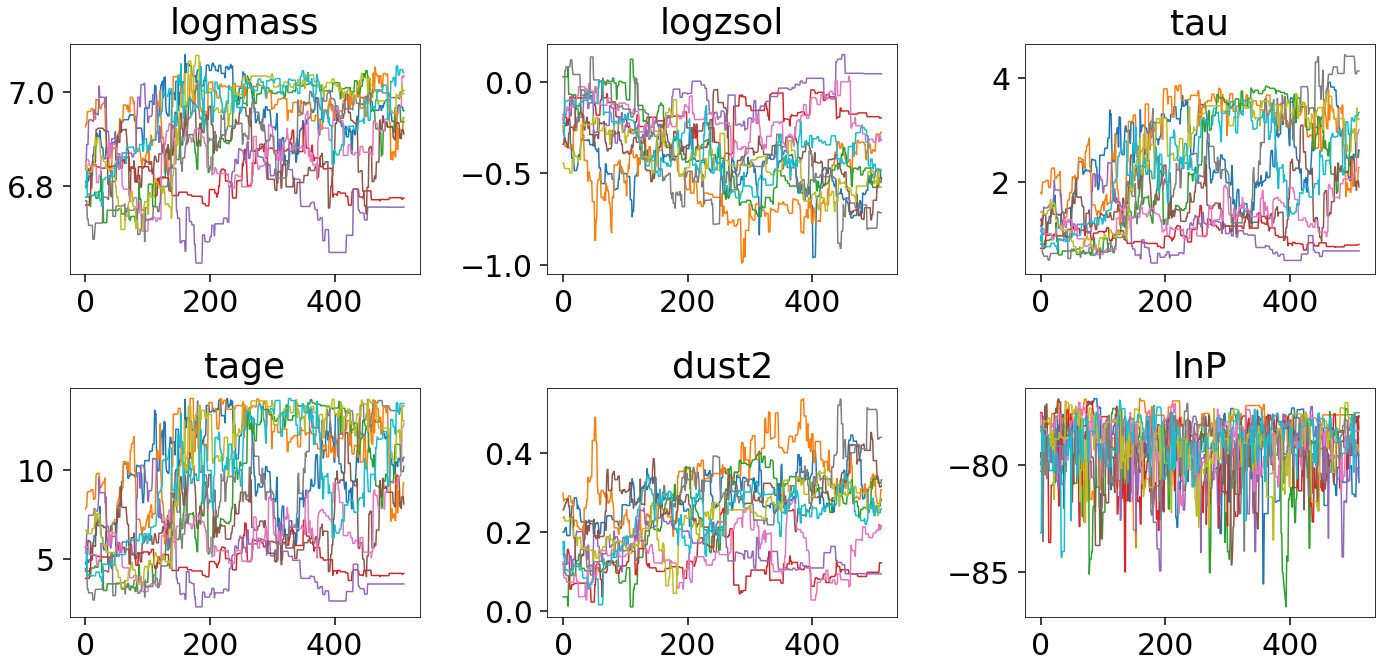

In [23]:
tracefig = pread.param_evol(res, figsize=(20,10), chains=choice(128, size=10, replace=False))

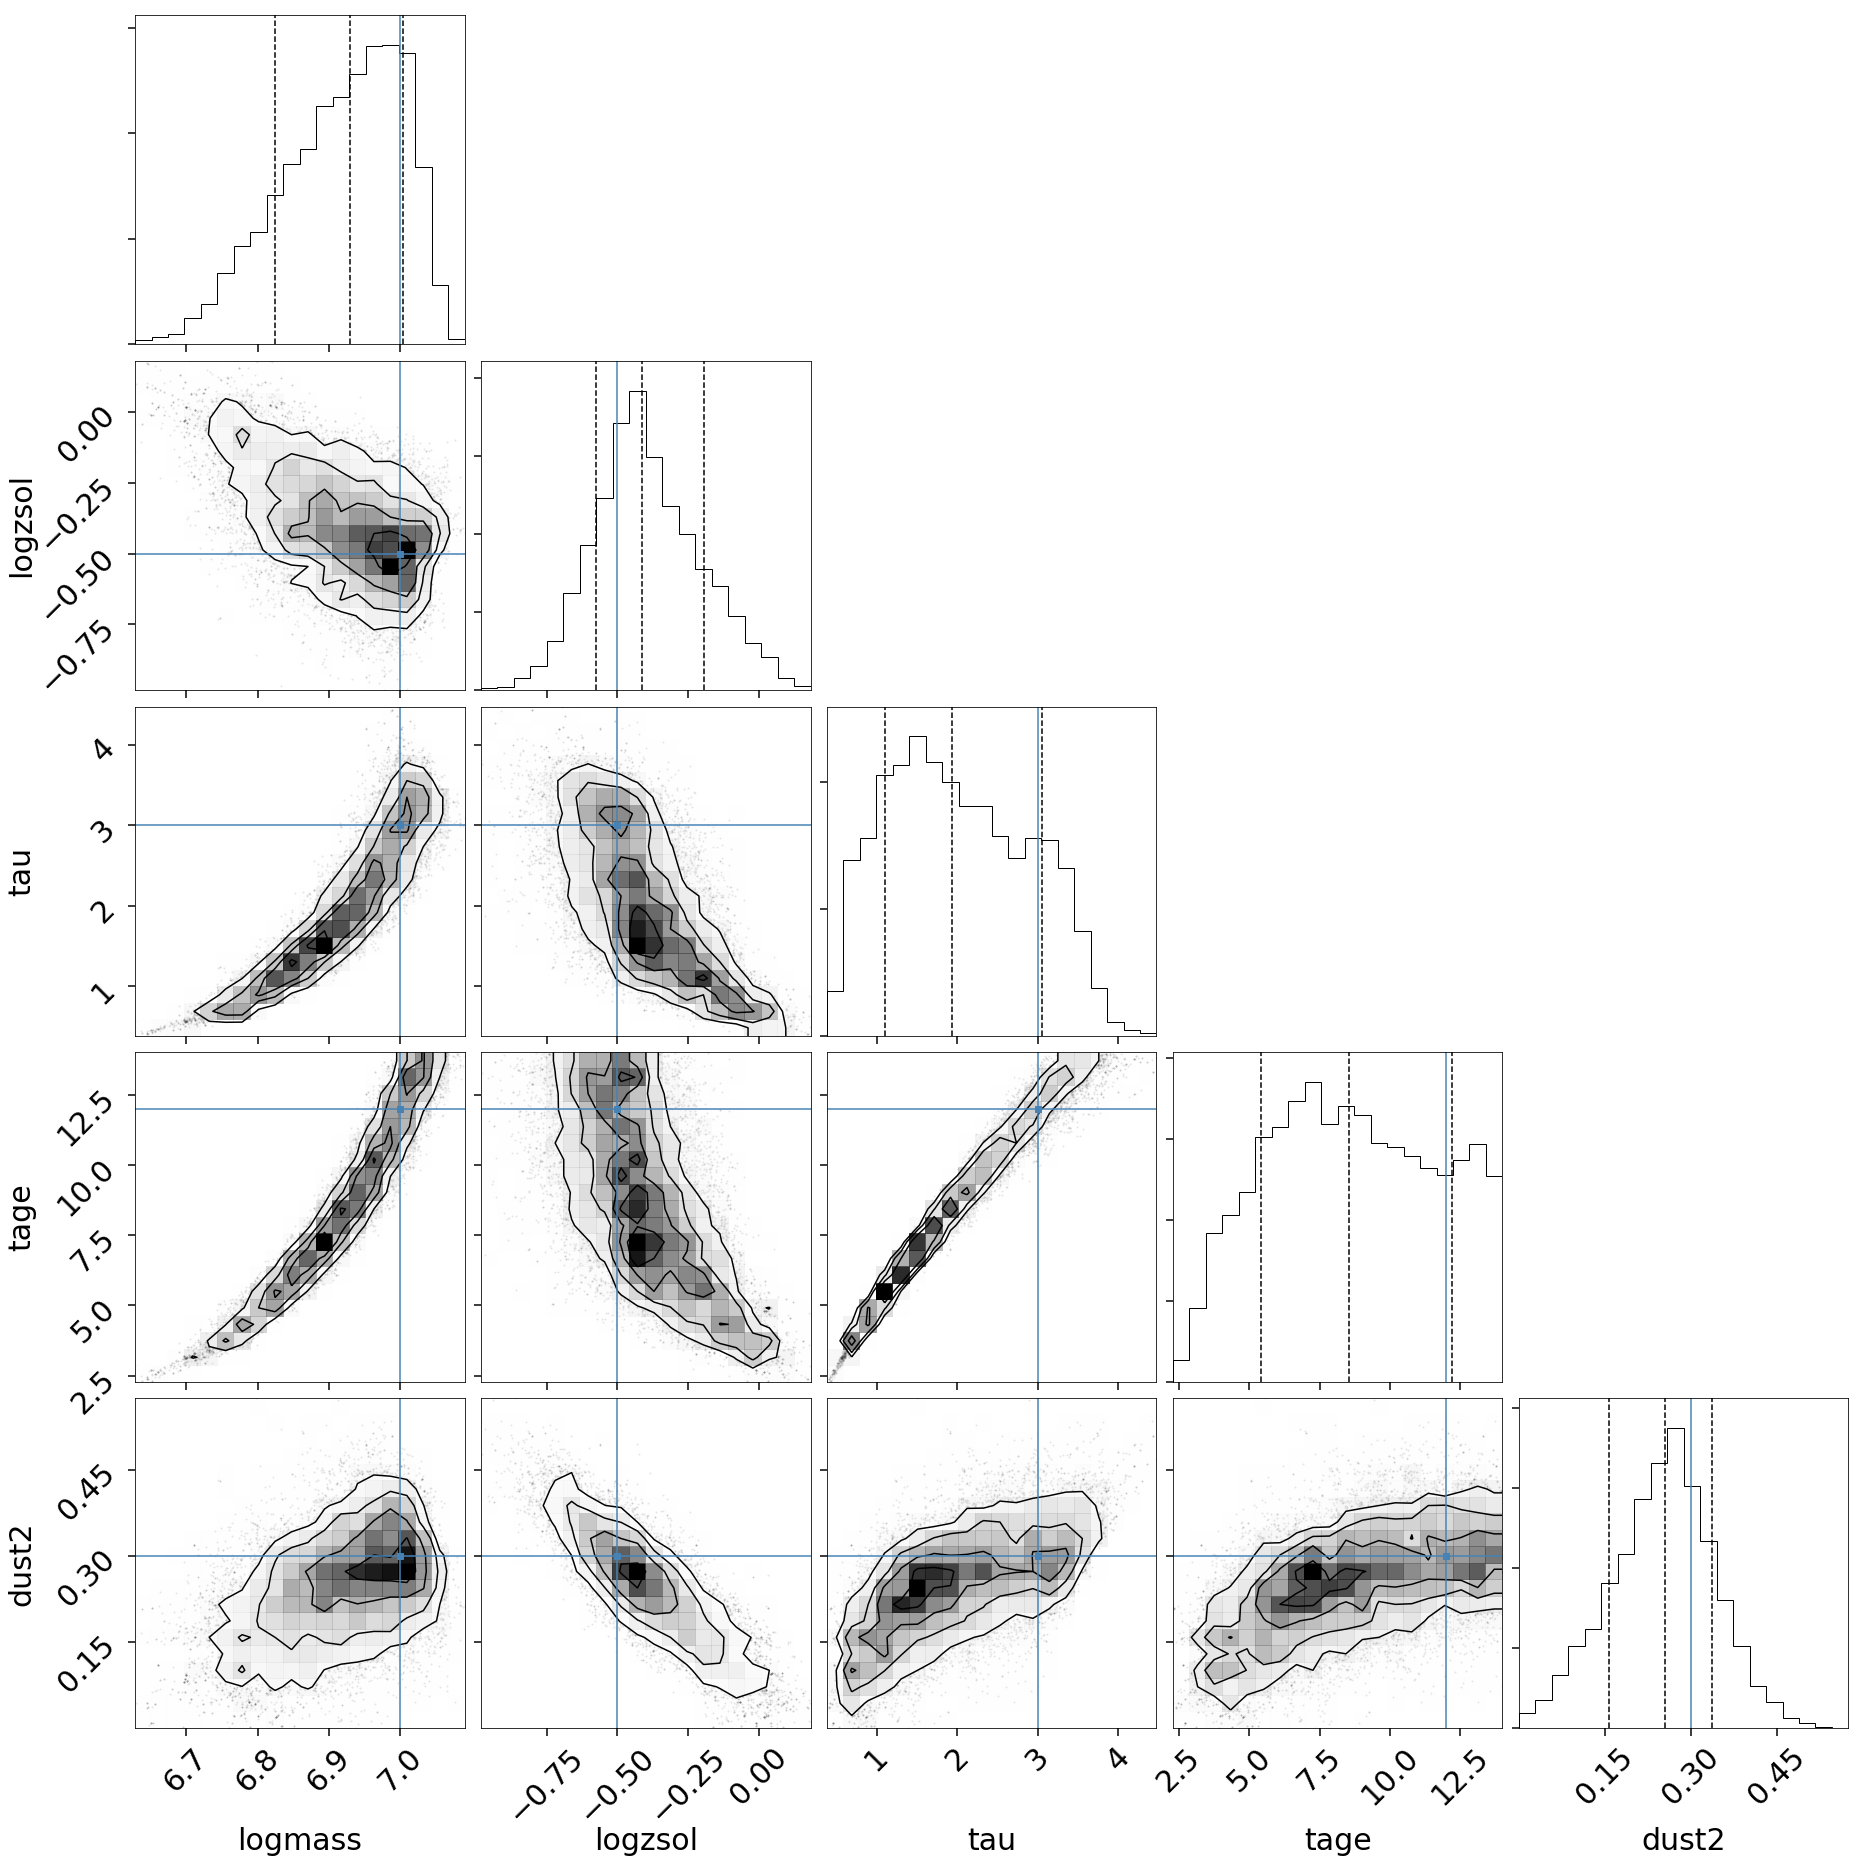

In [24]:
theta_truth = array([run_params[i] for i in ['mass','logzsol','tau','tage','dust2']])
theta_truth[0] = log10(theta_truth[0])
cornerfig = pread.subtriangle(res, start=0, thin=5, truths=theta_truth, 
                              fig=subplots(5,5,figsize=(27,27))[0])


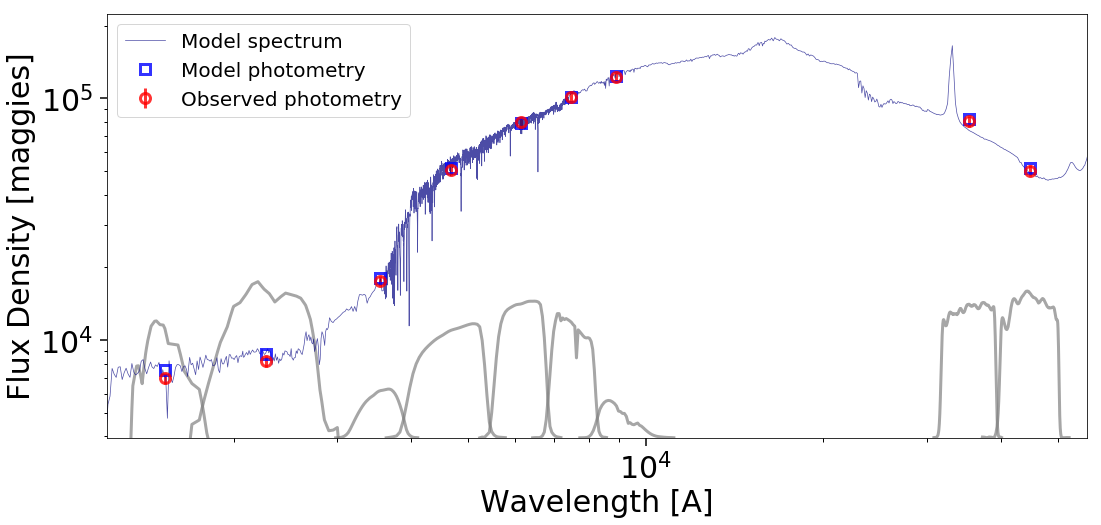

In [25]:
theta = res['chain'][randint(128), randint(512)] # initial parameters
mspec, mphot, mextra = model.mean_model(theta, obs, sps=sps) # generate model

# establish bounds
xmin, xmax = wphot.min()*0.8, wphot.max()/0.8
temp = interp(linspace(xmin,xmax,10000), wspec, mspec)
ymin, ymax = temp.min()*0.8, temp.max()/0.8

# plotting 
figure(figsize=(16,8))
for i in xrange(len(wphot)):
    f = obs['filters'][i]
    w, t = f.wavelength.copy(), f.transmission.copy()
    while t.max() > 1:
        t /= 10.
    t = 0.1*(ymax-ymin)*t + ymin
    loglog(w, t, lw=3, color='gray', alpha=0.7)
loglog(wspec, mspec, lw=0.7, color='navy', alpha=0.7, label='Model spectrum')
errorbar(wphot, mphot, marker='s', ls='', lw=3, markersize=10,
         markerfacecolor='none', markeredgecolor='blue', markeredgewidth=3, alpha=0.8, label='Model photometry')
errorbar(wphot, obs['maggies'], yerr=obs['maggies_unc'], ecolor='red', marker='o', ls='', lw=3, markersize=10, 
         markerfacecolor='none', markeredgecolor='red', markeredgewidth=3, alpha=0.8, label='Observed photometry')
xlabel('Wavelength [A]')
ylabel('Flux Density [maggies]')
xlim([xmin, xmax])
ylim([ymin, ymax])
legend(loc='best', fontsize=20)
tight_layout()
